In [1]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' 
}

# there are 155 slices per volume
VOLUME_SLICES = 128
VOLUME_START_AT = 13 # first slice of volume that we will include

In [2]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

In [4]:
import os
import numpy as np
import cv2
import tensorflow as tf
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [5]:
# General Dice Coefficient
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_pred_labels = tf.argmax(y_pred, axis=-1)  # shape (batch, D, H, W)
    y_true_labels = tf.argmax(y_true, axis=-1)
    num_classes=4
    dice_per_class = []
    for c in range(num_classes):
        y_true_c = tf.cast(tf.equal(y_true_labels, c), tf.float32)
        y_pred_c = tf.cast(tf.equal(y_pred_labels, c), tf.float32)
        
        intersection = tf.reduce_sum(y_true_c * y_pred_c)
        union = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c)
        dice = (2. * intersection + smooth) / (union + smooth)
        dice_per_class.append(dice)
    
    mean_dice = tf.reduce_mean(tf.stack(dice_per_class))
    return mean_dice
    
def dice_ET(y_true, y_pred, smooth=1e-6):
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    y_true_labels = tf.argmax(y_true, axis=-1)

    y_true_c = tf.cast(tf.equal(y_true_labels, 3), tf.float32)
    y_pred_c = tf.cast(tf.equal(y_pred_labels, 3), tf.float32)

    intersection = tf.reduce_sum(y_true_c * y_pred_c)
    union = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c)
    dice = (2. * intersection + smooth) / (union + smooth)

    return dice

def dice_TC(y_true, y_pred, smooth=1e-6):
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    y_true_labels = tf.argmax(y_true, axis=-1)

    y_true_c = tf.cast(tf.logical_or(tf.equal(y_true_labels, 1), tf.equal(y_true_labels, 3)), tf.float32)
    y_pred_c = tf.cast(tf.logical_or(tf.equal(y_pred_labels, 1), tf.equal(y_pred_labels, 3)), tf.float32)

    intersection = tf.reduce_sum(y_true_c * y_pred_c)
    union = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c)
    dice = (2. * intersection + smooth) / (union + smooth)

    return dice

def dice_WT(y_true, y_pred, smooth=1e-6):
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    y_true_labels = tf.argmax(y_true, axis=-1)

    y_true_c = tf.cast(tf.logical_or(
        tf.logical_or(tf.equal(y_true_labels, 1), tf.equal(y_true_labels, 2)),
        tf.equal(y_true_labels, 3)
    ), tf.float32)

    y_pred_c = tf.cast(tf.logical_or(
        tf.logical_or(tf.equal(y_pred_labels, 1), tf.equal(y_pred_labels, 2)),
        tf.equal(y_pred_labels, 3)
    ), tf.float32)

    intersection = tf.reduce_sum(y_true_c * y_pred_c)
    union = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c)
    dice = (2. * intersection + smooth) / (union + smooth)

    return dice

In [6]:
def mean_iou(y_true, y_pred, smooth=1e-6):
    y_pred_labels = tf.argmax(y_pred, axis=-1)  # shape: (batch, D, H, W)
    y_true_labels = tf.argmax(y_true, axis=-1)  # same shape

    num_classes = 4
    iou_per_class = []

    for c in range(num_classes):
        y_true_c = tf.cast(tf.equal(y_true_labels, c), tf.float32)
        y_pred_c = tf.cast(tf.equal(y_pred_labels, c), tf.float32)

        intersection = tf.reduce_sum(y_true_c * y_pred_c)
        union = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c) - intersection

        iou = (intersection + smooth) / (union + smooth)
        iou_per_class.append(iou)

    mean_iou = tf.reduce_mean(tf.stack(iou_per_class))
    return mean_iou

def iou_ET(y_true, y_pred, smooth=1e-6):
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    y_true_labels = tf.argmax(y_true, axis=-1)

    y_true_c = tf.cast(tf.equal(y_true_labels, 3), tf.float32)
    y_pred_c = tf.cast(tf.equal(y_pred_labels, 3), tf.float32)

    intersection = tf.reduce_sum(y_true_c * y_pred_c)
    union = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c) - intersection
    iou = (intersection + smooth) / (union + smooth)

    return iou

def iou_TC(y_true, y_pred, smooth=1e-6):
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    y_true_labels = tf.argmax(y_true, axis=-1)

    y_true_c = tf.cast(tf.logical_or(tf.equal(y_true_labels, 1), tf.equal(y_true_labels, 3)), tf.float32)
    y_pred_c = tf.cast(tf.logical_or(tf.equal(y_pred_labels, 1), tf.equal(y_pred_labels, 3)), tf.float32)

    intersection = tf.reduce_sum(y_true_c * y_pred_c)
    union = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c) - intersection
    iou = (intersection + smooth) / (union + smooth)

    return iou

def iou_WT(y_true, y_pred, smooth=1e-6):
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    y_true_labels = tf.argmax(y_true, axis=-1)

    y_true_c = tf.cast(tf.logical_or(
        tf.logical_or(tf.equal(y_true_labels, 1), tf.equal(y_true_labels, 2)),
        tf.equal(y_true_labels, 3)
    ), tf.float32)

    y_pred_c = tf.cast(tf.logical_or(
        tf.logical_or(tf.equal(y_pred_labels, 1), tf.equal(y_pred_labels, 2)),
        tf.equal(y_pred_labels, 3)
    ), tf.float32)

    intersection = tf.reduce_sum(y_true_c * y_pred_c)
    union = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c) - intersection
    iou = (intersection + smooth) / (union + smooth)

    return iou


In [7]:
def sensitivity_ET(y_true, y_pred, smooth=1e-6):
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    y_true_labels = tf.argmax(y_true, axis=-1)

    y_true_c = tf.cast(tf.equal(y_true_labels, 3), tf.float32)
    y_pred_c = tf.cast(tf.equal(y_pred_labels, 3), tf.float32)

    tp = tf.reduce_sum(y_true_c * y_pred_c)
    fn = tf.reduce_sum(y_true_c * (1 - y_pred_c))

    sensitivity = (tp + smooth) / (tp + fn + smooth)
    return sensitivity
    
def sensitivity_TC(y_true, y_pred, smooth=1e-6):
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    y_true_labels = tf.argmax(y_true, axis=-1)

    y_true_c = tf.cast(tf.logical_or(tf.equal(y_true_labels, 1), tf.equal(y_true_labels, 3)), tf.float32)
    y_pred_c = tf.cast(tf.logical_or(tf.equal(y_pred_labels, 1), tf.equal(y_pred_labels, 3)), tf.float32)

    tp = tf.reduce_sum(y_true_c * y_pred_c)
    fn = tf.reduce_sum(y_true_c * (1 - y_pred_c))

    sensitivity = (tp + smooth) / (tp + fn + smooth)
    return sensitivity

def sensitivity_WT(y_true, y_pred, smooth=1e-6):
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    y_true_labels = tf.argmax(y_true, axis=-1)

    y_true_c = tf.cast(tf.logical_or(
        tf.logical_or(tf.equal(y_true_labels, 1), tf.equal(y_true_labels, 2)),
        tf.equal(y_true_labels, 3)
    ), tf.float32)

    y_pred_c = tf.cast(tf.logical_or(
        tf.logical_or(tf.equal(y_pred_labels, 1), tf.equal(y_pred_labels, 2)),
        tf.equal(y_pred_labels, 3)
    ), tf.float32)

    tp = tf.reduce_sum(y_true_c * y_pred_c)
    fn = tf.reduce_sum(y_true_c * (1 - y_pred_c))

    sensitivity = (tp + smooth) / (tp + fn + smooth)
    return sensitivity


In [8]:
def specificity_ET(y_true, y_pred, smooth=1e-6):
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    y_true_labels = tf.argmax(y_true, axis=-1)

    y_true_c = tf.cast(tf.equal(y_true_labels, 3), tf.float32)
    y_pred_c = tf.cast(tf.equal(y_pred_labels, 3), tf.float32)

    tn = tf.reduce_sum((1 - y_true_c) * (1 - y_pred_c))
    fp = tf.reduce_sum((1 - y_true_c) * y_pred_c)

    specificity = (tn + smooth) / (tn + fp + smooth)
    return specificity

def specificity_TC(y_true, y_pred, smooth=1e-6):
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    y_true_labels = tf.argmax(y_true, axis=-1)

    y_true_c = tf.cast(tf.logical_or(tf.equal(y_true_labels, 1), tf.equal(y_true_labels, 3)), tf.float32)
    y_pred_c = tf.cast(tf.logical_or(tf.equal(y_pred_labels, 1), tf.equal(y_pred_labels, 3)), tf.float32)

    tn = tf.reduce_sum((1 - y_true_c) * (1 - y_pred_c))
    fp = tf.reduce_sum((1 - y_true_c) * y_pred_c)

    specificity = (tn + smooth) / (tn + fp + smooth)
    return specificity

def specificity_WT(y_true, y_pred, smooth=1e-6):
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    y_true_labels = tf.argmax(y_true, axis=-1)

    y_true_c = tf.cast(tf.logical_or(
        tf.logical_or(tf.equal(y_true_labels, 1), tf.equal(y_true_labels, 2)),
        tf.equal(y_true_labels, 3)
    ), tf.float32)

    y_pred_c = tf.cast(tf.logical_or(
        tf.logical_or(tf.equal(y_pred_labels, 1), tf.equal(y_pred_labels, 2)),
        tf.equal(y_pred_labels, 3)
    ), tf.float32)

    tn = tf.reduce_sum((1 - y_true_c) * (1 - y_pred_c))
    fp = tf.reduce_sum((1 - y_true_c) * y_pred_c)

    specificity = (tn + smooth) / (tn + fp + smooth)
    return specificity


In [9]:
def categorical_focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_pred = tf.clip_by_value(y_pred, 1e-8, 1.0)
    cross_entropy = -y_true * tf.math.log(y_pred)
    weight = alpha * tf.pow(1 - y_pred, gamma)
    loss = weight * cross_entropy  # shape: (batch, H, W, D, C)
    loss = tf.reduce_sum(loss, axis=-1)  # shape: (batch, H, W, D)
    per_sample_loss = tf.reduce_mean(loss, axis=[1, 2, 3])  # shape: (batch,)
    return per_sample_loss

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice = (2. * intersection + smooth) / (union + smooth)
    dice_per_sample = tf.reduce_mean(dice, axis=-1)
    return 1.0 - dice_per_sample

In [10]:
# combine dice_loss and categorical crossentropy as loss function
def combined_loss_weighted(y_true, y_pred):
    focal_loss = categorical_focal_loss(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return 0.5*focal_loss + 0.5*dice

In [11]:
IMG_SIZE=128

In [12]:
def attention_gate(x, g, inter_channels):
    theta_x = Conv3D(inter_channels, kernel_size=1, strides=1, padding='same')(x)
    phi_g = Conv3D(inter_channels, kernel_size=1, strides=1, padding='same')(g)
    add = tf.keras.layers.add([theta_x, phi_g])
    act = ReLU()(add)
    psi = Conv3D(1, kernel_size=1, strides=1, padding='same')(act)
    psi = Activation('sigmoid')(psi)
    attn = tf.keras.layers.multiply([x, psi])
    return attn

def residual_block(x, filters, kernel_initializer='he_normal', dropout_rate=0.1):
    shortcut = x
    if x.shape[-1] != filters:
        shortcut = Conv3D(filters, (1, 1, 1), padding='same',
                          kernel_initializer=kernel_initializer,
                          kernel_regularizer=l2(1e-4))(shortcut)
        shortcut = GroupNormalization(groups=8)(shortcut)

    x = Conv3D(filters, (3, 3, 3), padding='same',
               kernel_initializer=kernel_initializer,
               kernel_regularizer=l2(1e-4))(x)
    x = GroupNormalization(groups=8)(x)
    x = ReLU()(x)

    x = Conv3D(filters, (3, 3, 3), padding='same',
               kernel_initializer=kernel_initializer,
               kernel_regularizer=l2(1e-4))(x)
    x = GroupNormalization(groups=8)(x)

    x = Add()([shortcut, x])
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)
    return x

def build_unet(inputs, kernel_initializer='he_normal'):
    # Encoder
    c1 = residual_block(inputs, 32, kernel_initializer, dropout_rate=0.1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = residual_block(p1, 64, kernel_initializer, dropout_rate=0.1)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = residual_block(p2, 128, kernel_initializer, dropout_rate=0.2)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = residual_block(p3, 256, kernel_initializer, dropout_rate=0.2)
    p4 = MaxPooling3D((2, 2, 2))(c4)

    c5 = residual_block(p4, 512, kernel_initializer, dropout_rate=0.3)
    p5 = MaxPooling3D((2, 2, 2))(c5)

    c6 = residual_block(p5, 1024, kernel_initializer, dropout_rate=0.3)

    # Decoder with attention
    u7 = Conv3DTranspose(512, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    attn_c5 = attention_gate(c5, u7, 256)
    u7 = concatenate([u7, attn_c5])
    c7 = residual_block(u7, 512, kernel_initializer, dropout_rate=0.3)

    u8 = Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    attn_c4 = attention_gate(c4, u8, 128)
    u8 = concatenate([u8, attn_c4])
    c8 = residual_block(u8, 256, kernel_initializer, dropout_rate=0.2)

    u9 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    attn_c3 = attention_gate(c3, u9, 64)
    u9 = concatenate([u9, attn_c3])
    c9 = residual_block(u9, 128, kernel_initializer, dropout_rate=0.2)

    u10 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c9)
    attn_c2 = attention_gate(c2, u10, 32)
    u10 = concatenate([u10, attn_c2])
    c10 = residual_block(u10, 64, kernel_initializer, dropout_rate=0.1)

    u11 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c10)
    attn_c1 = attention_gate(c1, u11, 16)
    u11 = concatenate([u11, attn_c1])
    c11 = residual_block(u11, 32, kernel_initializer, dropout_rate=0.1)

    outputs = Conv3D(4, (1, 1, 1), activation='softmax')(c11)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [13]:
input_layer = Input((IMG_SIZE, IMG_SIZE, IMG_SIZE, 4))

In [15]:

model = build_unet(input_layer, 'he_normal')

model.compile(
    loss=combined_loss_weighted,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[
        'accuracy', dice_coef, dice_ET, dice_TC, dice_WT, mean_iou,
        iou_ET, iou_TC, iou_WT, sensitivity_ET, sensitivity_TC,
        sensitivity_WT, specificity_ET, specificity_TC, specificity_WT] )


In [16]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 128,  │              0 │ -                      │
│                           │ 4)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_50 (Conv3D)        │ (None, 128, 128, 128,  │          3,488 │ input_layer[0][0]      │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_34    │ (None, 128, 128, 128,  │             64 │ conv3d_50[0][0]        │
│ (GroupNormalization)      │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_27 (ReLU)           │ (None, 128, 128, 128,  │              0 │ group_normalization_3… │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_49 (Conv3D)        │ (None, 128, 128, 128,  │            160 │ input_layer[0][0]      │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_51 (Conv3D)        │ (None, 128, 128, 128,  │         27,680 │ re_lu_27[0][0]         │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_33    │ (None, 128, 128, 128,  │             64 │ conv3d_49[0][0]        │
│ (GroupNormalization)      │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_35    │ (None, 128, 128, 128,  │             64 │ conv3d_51[0][0]        │
│ (GroupNormalization)      │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_16 (Add)              │ (None, 128, 128, 128,  │              0 │ group_normalization_3… │
│                           │ 32)                    │                │ group_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_28 (ReLU)           │ (None, 128, 128, 128,  │              0 │ add_16[0][0]           │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 128, 128, 128,  │              0 │ re_lu_28[0][0]         │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_5           │ (None, 64, 64, 64, 32) │              0 │ dropout_11[0][0]       │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_53 (Conv3D)        │ (None, 64, 64, 64, 64) │         55,360 │ max_pooling3d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_3

 Total params: 92,245,497 (351.89 MB)

 Trainable params: 92,245,497 (351.89 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# Remove the directory with the ill-formatted name
ill_formatted_dir = os.path.join(TRAIN_DATASET_PATH, 'BraTS20_Training_355')
if ill_formatted_dir in train_and_val_directories:
    train_and_val_directories.remove(ill_formatted_dir)

def pathListIntoIds(dir_list):
    return [os.path.basename(d) for d in dir_list]

train_and_test_ids = pathListIntoIds(train_and_val_directories)

# Split into training and validation
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.17)

# Split the training set into training and testing
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.14)

print(f"Training IDs: {train_ids}")
print(f"Validation IDs: {val_ids}")
print(f"Test IDs: {test_ids}")

Training IDs: ['BraTS20_Training_132', 'BraTS20_Training_033', 'BraTS20_Training_269', 'BraTS20_Training_020', 'BraTS20_Training_027', 'BraTS20_Training_025', 'BraTS20_Training_192', 'BraTS20_Training_139', 'BraTS20_Training_068', 'BraTS20_Training_143', 'BraTS20_Training_219', 'BraTS20_Training_150', 'BraTS20_Training_221', 'BraTS20_Training_197', 'BraTS20_Training_340', 'BraTS20_Training_322', 'BraTS20_Training_147', 'BraTS20_Training_345', 'BraTS20_Training_024', 'BraTS20_Training_312', 'BraTS20_Training_363', 'BraTS20_Training_213', 'BraTS20_Training_352', 'BraTS20_Training_281', 'BraTS20_Training_082', 'BraTS20_Training_120', 'BraTS20_Training_041', 'BraTS20_Training_116', 'BraTS20_Training_182', 'BraTS20_Training_261', 'BraTS20_Training_233', 'BraTS20_Training_184', 'BraTS20_Training_171', 'BraTS20_Training_169', 'BraTS20_Training_325', 'BraTS20_Training_031', 'BraTS20_Training_332', 'BraTS20_Training_236', 'BraTS20_Training_231', 'BraTS20_Training_045', 'BraTS20_Training_255', '

In [18]:
print(len(train_ids),len(val_ids),len(test_ids))

262 63 43


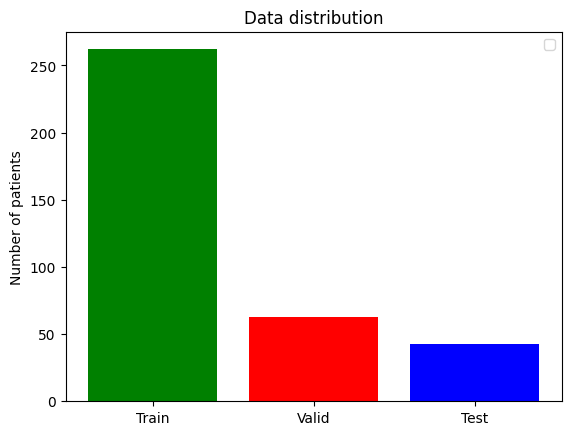

In [19]:
import matplotlib.pyplot as plt
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of patients')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [20]:
class DataGenerator3D(Sequence):
    def __init__(self, list_IDs, batch_size=1, dim=(128, 128, 128), n_channels=4, n_classes=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim  # (H, W, D)
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def normalize_volume(self, volume):
        mean = np.mean(volume)
        std = np.std(volume)
        return (volume - mean) / (std + 1e-8)

    def augment_data(self, volume, label):
        # Random flip
        if np.random.rand() > 0.5:
            volume = np.flip(volume, axis=0)
            label = np.flip(label, axis=0)
        if np.random.rand() > 0.5:
            volume = np.flip(volume, axis=1)
            label = np.flip(label, axis=1)
        if np.random.rand() > 0.5:
            volume = np.flip(volume, axis=2)
            label = np.flip(label, axis=2)

        # Random rotation (90-degree multiples) along axial plane
        k = np.random.randint(0, 4)
        volume = np.rot90(volume, k, axes=(0, 1))
        label = np.rot90(label, k, axes=(0, 1))

        # Intensity shift
        for c in range(volume.shape[-1]):
            if np.random.rand() > 0.5:
                shift = np.random.uniform(-0.1, 0.1)
                volume[..., c] += shift

        # Add Gaussian noise
        if np.random.rand() > 0.5:
            noise = np.random.normal(0, 0.05, size=volume.shape)
            volume += noise

        return volume, label

    def __data_generation(self, batch_ids):
        X = np.zeros((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
        Y = np.zeros((self.batch_size, *self.dim, self.n_classes), dtype=np.float32)

        for i, ID in enumerate(batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, ID)

            try:
                flair = nib.load(os.path.join(case_path, f'{ID}_flair.nii')).get_fdata()
                t2 = nib.load(os.path.join(case_path, f'{ID}_t2.nii')).get_fdata()
                ce = nib.load(os.path.join(case_path, f'{ID}_t1ce.nii')).get_fdata()
                t1 = nib.load(os.path.join(case_path, f'{ID}_t1.nii')).get_fdata()
                seg = nib.load(os.path.join(case_path, f'{ID}_seg.nii')).get_fdata()

                # Normalize
                flair = self.normalize_volume(flair)
                t2 = self.normalize_volume(t2)
                ce = self.normalize_volume(ce)
                t1 = self.normalize_volume(t1)

                # Stack modalities
                volume = np.stack([flair, t2, ce, t1], axis=-1)  # Shape: (240, 240, 155, 4)
                volume = volume[56:184, 56:184, 13:141]          # Shape: (128, 128, 128, 4)

                # Prepare segmentation mask
                seg = np.where(seg == 4, 3, seg)
                seg = seg[56:184, 56:184, 13:141]               # Shape: (128, 128, 128)
                label = tf.one_hot(seg, depth=self.n_classes).numpy()  # Shape: (128, 128, 128, 4)

                # Apply augmentation
                volume, label = self.augment_data(volume, label)

                X[i] = volume
                Y[i] = label

            except Exception as e:
                print(f"[ERROR] Loading {ID}: {e}")

        return X, Y

In [21]:
# Create generators
training_generator = DataGenerator3D(train_ids)
valid_generator = DataGenerator3D(val_ids)
test_generator = DataGenerator3D(test_ids)

In [22]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                               patience=5, verbose=1, mode='auto'),
      tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25,
                               patience=2, min_lr=0.000001, verbose=1),
      csv_logger
      ]

In [23]:
# Train the model
K.clear_session()
history = model.fit(
    training_generator,
    validation_data=valid_generator,
    epochs=40,
    callbacks=callbacks    
)
model.save('BraTS_Trained_ResUNet_seg_Model1.h5')

Epoch 1/40


I0000 00:00:1748060836.308756      99 service.cc:148] XLA service 0x7be6340028a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748060836.310529      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748060836.310551      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748060841.480166      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1748060845.789527      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748060845.947108      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748060846.086329      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9598 - dice_coef: 0.4885 - dice_et: 0.3784 - dice_tc: 0.3689 - dice_wt: 0.5942 - iou_et: 0.2877 - iou_tc: 0.2713 - iou_wt: 0.4864 - loss: 1.5760 - mean_iou: 0.4180 - sensitivity_et: 0.4622 - sensitivity_tc: 0.4197 - sensitivity_wt: 0.6045 - specificity_et: 0.9928 - specificity_tc: 0.9902 - specificity_wt: 0.9842

E0000 00:00:1748061568.687023      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748061568.851191      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


262/262 ━━━━━━━━━━━━━━━━━━━━ 922s 3s/step - accuracy: 0.9598 - dice_coef: 0.4888 - dice_et: 0.3789 - dice_tc: 0.3695 - dice_wt: 0.5948 - iou_et: 0.2882 - iou_tc: 0.2718 - iou_wt: 0.4869 - loss: 1.5745 - mean_iou: 0.4183 - sensitivity_et: 0.4628 - sensitivity_tc: 0.4203 - sensitivity_wt: 0.6051 - specificity_et: 0.9928 - specificity_tc: 0.9902 - specificity_wt: 0.9842 - val_accuracy: 0.9799 - val_dice_coef: 0.6677 - val_dice_et: 0.6433 - val_dice_tc: 0.6612 - val_dice_wt: 0.8528 - val_iou_et: 0.5233 - val_iou_tc: 0.5198 - val_iou_wt: 0.7524 - val_loss: 0.7142 - val_mean_iou: 0.5722 - val_sensitivity_et: 0.8345 - val_sensitivity_tc: 0.8322 - val_sensitivity_wt: 0.8630 - val_specificity_et: 0.9972 - val_specificity_tc: 0.9927 - val_specificity_wt: 0.9958 - learning_rate: 1.0000e-04
Epoch 2/40
262/262 ━━━━━━━━━━━━━━━━━━━━ 775s 3s/step - accuracy: 0.9759 - dice_coef: 0.6603 - dice_et: 0.6551 - dice_tc: 0.6488 - dice_wt: 0.8284 - iou_et: 0.5328 - iou_tc: 0.5235 - iou_wt: 0.7318 - loss: 0.659

In [24]:
results = model.evaluate(test_generator)
print(f"Test results: {results}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9840 - dice_coef: 0.8077 - dice_et: 0.7070 - dice_tc: 0.8573 - dice_wt: 0.9169 - iou_et: 0.6150 - iou_tc: 0.7734 - iou_wt: 0.8498 - loss: 0.1954 - mean_iou: 0.7242 - sensitivity_et: 0.8600 - sensitivity_tc: 0.8520 - sensitivity_wt: 0.9144 - specificity_et: 0.9988 - specificity_tc: 0.9969 - specificity_wt: 0.9972
Test results: [0.20220503211021423, 0.9861332178115845, 0.7916153073310852, 0.7067298293113708, 0.8323377370834351, 0.9140418171882629, 0.7071525454521179, 0.6124029159545898, 0.7448841333389282, 0.8449576497077942, 0.8435180187225342, 0.8355525732040405, 0.9189550876617432, 0.9988510012626648, 0.9971311092376709, 0.9966234564781189]


In [25]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 128,  │              0 │ -                      │
│                           │ 4)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_50 (Conv3D)        │ (None, 128, 128, 128,  │          3,488 │ input_layer[0][0]      │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_34    │ (None, 128, 128, 128,  │             64 │ conv3d_50[0][0]        │
│ (GroupNormalization)      │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_27 (ReLU)           │ (None, 128, 128, 128,  │              0 │ group_normalization_3… │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_49 (Conv3D)        │ (None, 128, 128, 128,  │            160 │ input_layer[0][0]      │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_51 (Conv3D)        │ (None, 128, 128, 128,  │         27,680 │ re_lu_27[0][0]         │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_33    │ (None, 128, 128, 128,  │             64 │ conv3d_49[0][0]        │
│ (GroupNormalization)      │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_35    │ (None, 128, 128, 128,  │             64 │ conv3d_51[0][0]        │
│ (GroupNormalization)      │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_16 (Add)              │ (None, 128, 128, 128,  │              0 │ group_normalization_3… │
│                           │ 32)                    │                │ group_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_28 (ReLU)           │ (None, 128, 128, 128,  │              0 │ add_16[0][0]           │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 128, 128, 128,  │              0 │ re_lu_28[0][0]         │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_5           │ (None, 64, 64, 64, 32) │              0 │ dropout_11[0][0]       │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_53 (Conv3D)        │ (None, 64, 64, 64, 64) │         55,360 │ max_pooling3d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_3

 Total params: 276,736,493 (1.03 GB)

 Trainable params: 92,245,497 (351.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 184,490,996 (703.78 MB)